In [1]:
!pip install efficientnet_pytorch torchtoolbox

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 11.8 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=98c6d57d0c075cce1d1fdd8b733afb8a402c281f8ce95bb1babbeb56444366b9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [18]:
# importing libraries
# Author of dataloader code - Rafael Kollorous
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
warnings.simplefilter('ignore')

class MelanomaDataset(Dataset):
    def __init__(self, df, img_path, train, image_transforms):
        self.df = df
        self.img_path = img_path
        self.train = train
        self.transform = image_transforms
        
    def __getitem__(self, index):

        image_path = os.path.join(self.img_path, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(image_path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x, (224, 224))
        x = np.array(Image.fromarray(x))
        x = self.transform(x)

        if self.train:
          y = self.df.iloc[index]['target']
          return x, y.astype("float32")
        else:
          return x
    
    def __len__(self):
        return len(self.df)

train_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

positive_classes = train_df[train_df['target'] == 1]
negative_classes = train_df[train_df['target'] == 0][:len(positive_classes)]

train_df = pd.concat([positive_classes, negative_classes])

X = train_df[['image_name', 'target']]
y = train_df['target']

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=1999, stratify=y)

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = MelanomaDataset(df=train_df,
                                img_path='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/',
                                train=True,
                                image_transforms = train_transform)
val_dataset = MelanomaDataset(df=valid_df,
                                img_path='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/',
                                train=True,
                                image_transforms = test_transform)
test_dataset = MelanomaDataset(df=test_df,
                               img_path='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/',
                               train=False,
                               image_transforms = test_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [16]:
#author - Ankita Bhatt
batch_size = val_loader.batch_size
num_batches = len(val_loader)
total_images = batch_size * num_batches
print("Total number of images in the validation loader:", total_images)

Total number of images in the validation loader: 128


In [5]:
#author - Ankita Bhatt
import torch.nn as nn

# Defining the CNN model
model = nn.Sequential(
    # Convolutional layers
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    # Flatten layer
    nn.Flatten(),
    
    # Fully connected layers
    nn.Linear(25088, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [6]:
#author - Ankita Bhatt
import torch.optim as optim
cnn_optimizer = optim.Adam(model.parameters(), lr=0.001)
cnn_criterion = nn.BCEWithLogitsLoss()

In [7]:
#author - Ankita Bhatt
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# nvidia-smi

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5076583127697782303
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13840941056
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4816284798366617913
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 13840941056
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 11714294030094807903
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


In [8]:
#author - Ankita Bhatt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
for param in model.parameters():
    param.requires_grad = True

In [9]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install coremltools==5.0b3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.3/890.3 kB 13.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for coremltools: filename=coremltools-5.0b3-py3-none-any.whl size=1176803 sha256=02030f20d33fa975cab760ac6069831d21c85c6a37d8fb98f4799a80e33a0a0c
  Stored in directory: /root/.cache/pip/wheels/69/6e/f9/8b9ba902e61a114ab9148ee9693be6c786b70e8f4b0f43ec52
Successfully built coremltools


In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [46]:
#author - Rafael Kollorous , Updated and Modified - Ankita Bhatt
from tqdm import tqdm

scheduler = None
def train(loader, model, criterion, optimizer, scheduler = None):
    loss_epoch = 0
    corrects = 0.0
    true_labels = []
    predicted_labels = []
    model.eval()
    with tqdm(total=len(loader)) as pbar:
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).float()
            true_labels.extend(labels.detach().cpu().numpy())
            predicted_labels.extend(outputs.detach().cpu().numpy()) 
            labels = labels.long()
            loss = criterion(outputs, labels)
            loss_epoch += loss.item()

            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            pbar.update(1)
        return loss / len(train_loader),true_labels, predicted_labels

In [38]:
len(val_loader)

14

In [ ]:
#author - Ankita Bhatt
tl = []
pl = []
for epoch in range(20):
    lossacc,tl,pl = train(train_loader,model,cnn_criterion,cnn_optimizer,scheduler)
    print(lossacc)

In [6]:
import torch
print(torch.cuda.is_available())

True


In [27]:
input_labels = []
pred_labels = []
for epoch in range(20):
    lossacc,input_labels,pred_labels = train(val_loader,model,cnn_criterion,cnn_optimizer,scheduler)
    print(lossacc)

100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


tensor(0.0457, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0381, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


tensor(0.0341, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


tensor(0.0355, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  2.00s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.98s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  2.00s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  2.00s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [00:30<00:00,  2.00s/it]

tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(input_labels, np.array(pred_labels) > 0.5)
f1 = f1_score(input_labels, np.array(pred_labels) > 0.5)
precision = precision_score(input_labels, np.array(pred_labels) > 0.5)
recall = recall_score(input_labels, np.array(pred_labels) > 0.5)

print(f'Accuracy: {accuracy} \t F1 Score: {f1} \t Precision: {precision} \t Recall: {recall}')

Accuracy: 0.8933760683760684 	 F1 Score: 0.8883918586445986 	 Precision: 0.9319568277803848 	 Recall: 0.8487179487179487


Hence the standard CNN model gives us accuracy of 89%

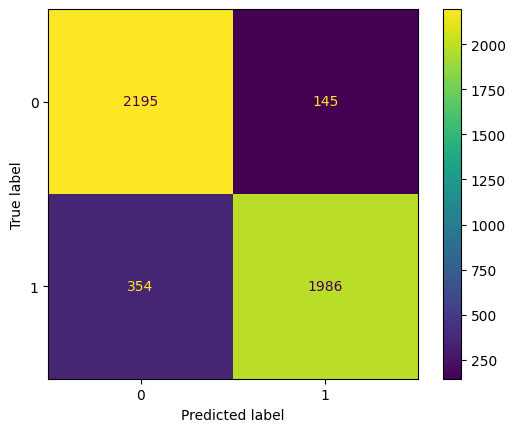

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(input_labels, np.array(pred_labels) > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [7]:
#author - Ankita Bhatt
from torchvision.models import squeezenet1_1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = squeezenet1_1(pretrained=True)
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
model.num_classes = num_classes
model = model.to(device)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 41.9MB/s]


In [8]:
#author - Ankita Bhatt
import torch.optim as optim
sq_criterion = nn.CrossEntropyLoss()
sq_optimizer = optim.Adam(model.parameters(), lr=0.001)

In [74]:
# training 
sq_tl = []
sq_pl = []
for epoch in range(50):
    lossacc,sq_tl,sq_pl = train(train_loader,model,sq_criterion,sq_optimizer,scheduler)
    print(lossacc)
    
# print(sq_pl)

100%|██████████| 14/14 [02:01<00:00,  8.65s/it]


tensor(0.0405, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.55s/it]


tensor(0.0428, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.56s/it]


tensor(0.0421, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.59s/it]


tensor(0.0375, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:57<00:00,  8.42s/it]


tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.53s/it]


tensor(0.0401, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.55s/it]


tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.56s/it]


tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.55s/it]


tensor(0.0403, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:01<00:00,  8.65s/it]


tensor(0.0269, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.56s/it]


tensor(0.0351, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.53s/it]


tensor(0.0281, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.60s/it]


tensor(0.0383, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.58s/it]


tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.59s/it]


tensor(0.0267, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.45s/it]


tensor(0.0380, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.48s/it]


tensor(0.0326, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:56<00:00,  8.33s/it]


tensor(0.0346, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.57s/it]


tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:51<00:00,  7.99s/it]


tensor(0.0300, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.53s/it]


tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.53s/it]


tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.46s/it]


tensor(0.0281, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.54s/it]


tensor(0.0275, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.55s/it]


tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:55<00:00,  8.27s/it]


tensor(0.0353, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.58s/it]


tensor(0.0340, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:06<00:00,  9.00s/it]


tensor(0.0251, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.51s/it]


tensor(0.0370, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.52s/it]


tensor(0.0242, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.55s/it]


tensor(0.0221, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.58s/it]


tensor(0.0273, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.47s/it]


tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.47s/it]


tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.61s/it]


tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.57s/it]


tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.51s/it]


tensor(0.0269, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.60s/it]


tensor(0.0210, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.59s/it]


tensor(0.0344, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.46s/it]


tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.52s/it]


tensor(0.0190, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.52s/it]


tensor(0.0194, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.62s/it]


tensor(0.0242, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:55<00:00,  8.26s/it]


tensor(0.0175, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.61s/it]


tensor(0.0517, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.59s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:59<00:00,  8.51s/it]


tensor(0.0256, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:00<00:00,  8.60s/it]


tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.45s/it]


tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [01:58<00:00,  8.49s/it]

tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)


In [30]:
len(sq_pl)

17920

In [47]:
# validating
sq_tvl = []
sq_pvl = []
for epoch in range(50):
    lossacc,sq_tvl,sq_pvl = train(val_loader,model,sq_criterion,sq_optimizer,scheduler)
    print(lossacc)

100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


tensor(0.0232, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


tensor(0.0164, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


tensor(0.0343, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.45s/it]


tensor(0.0139, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.43s/it]


tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [00:33<00:00,  2.40s/it]

tensor(3.4104e-05, device='cuda:0', grad_fn=<DivBackward0>)


In [55]:
print(sq_tvl)

[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0,

In [56]:
print(sq_pvl)

[array([ 1.7960356, 10.452666 ], dtype=float32), array([ 3.4190056, 48.133392 ], dtype=float32), array([18.636604 ,  4.3180594], dtype=float32), array([22.626696 , 11.2819195], dtype=float32), array([24.310003, 15.953815], dtype=float32), array([6.020734  , 0.92213327], dtype=float32), array([3.0734103, 1.1415772], dtype=float32), array([ 0.9855569, 20.84866  ], dtype=float32), array([17.358545 ,  2.2370648], dtype=float32), array([ 0.08214188, 27.282541  ], dtype=float32), array([ 0.35466558, 12.606869  ], dtype=float32), array([26.96198 ,  8.215897], dtype=float32), array([11.632994 ,  3.3628519], dtype=float32), array([2.4064107, 5.207917 ], dtype=float32), array([22.074966,  6.178384], dtype=float32), array([10.6932125, 24.92743  ], dtype=float32), array([25.838737,  8.981295], dtype=float32), array([ 8.60926 , 42.806194], dtype=float32), array([12.847393,  5.313358], dtype=float32), array([ 0.23152518, 16.556593  ], dtype=float32), array([22.05184  ,  3.1135077], dtype=float32), a

In [57]:
#author - Ankita Bhatt
# print(sq_pvl[0])
# predicted_labels = torch.tensor(sq_pvl)
# predicted_prl = torch.softmax(predicted_labels, dim=1)
# threshold = 0.5  # Set a threshold to determine the binary predicted output
# predicted_labels = (predicted_prl[:, 1] > threshold).long()

In [69]:
#author - Ankita Bhatt
list_of_preds = np.array(sq_pvl)
predicted_labels=[]
for arr in list_of_preds:
    if arr[0]>arr[1]:
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)
    

In [70]:
print(predicted_labels)

[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]


In [71]:
print(len(predicted_labels))

224


In [72]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
accuracy = accuracy_score(sq_tvl,predicted_labels)
f1 = f1_score(sq_tvl, predicted_labels)
precision = precision_score(sq_tvl, predicted_labels)
recall = recall_score(sq_tvl, predicted_labels)

print(f'Accuracy: {accuracy} \t F1 Score: {f1} \t Precision: {precision} \t Recall: {recall}')



Accuracy: 1.0 	 F1 Score: 1.0 	 Precision: 1.0 	 Recall: 1.0


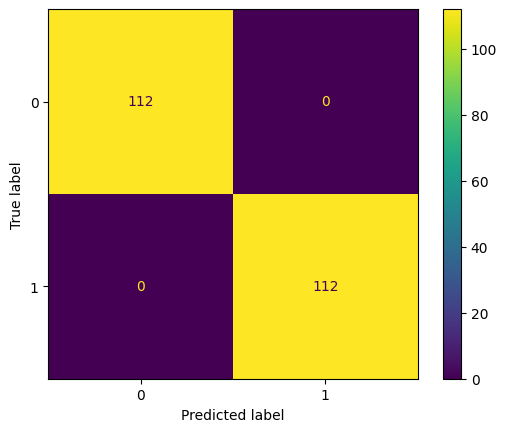

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(sq_tvl, np.array(predicted_labels) > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()